In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [2]:
MIN_MATCH_COUNT = 10

In [3]:
def load_img(imgName1, imgName2):
    img1 = cv2.imread(imgName1)  # trainImage
    img2 = cv2.imread(imgName2)  # queryImage
    return img1, img2

In [4]:
def dlt(f, t, num_points=4):
    """	Returns Homography matrix in which 'f' points are mapped to 't' points
        using Direct Linear Transform algorithm.
        t = Hf
    """
    assert f.shape == t.shape
    num_points = f.shape[0]
    A = np.zeros((2*num_points, 9))
    for p in range(num_points):
        fh = np.array([f[p,0], f[p,1], 1])										# Homogenous coordinate of point p
        A[2*p + 1] = np.concatenate(([0, 0, 0], -fh, t[p,1]*fh))					# [0' -wX' yX']
        A[2*p ] = np.concatenate((fh, [0, 0, 0], -t[p,0]*fh))				# [wX' 0' -xX']
    U, D, V = np.linalg.svd(A)
    H = V[8].reshape(3, 3)
    return H / H[-1,-1]        
        


In [5]:
def ransac(kp1,kp2,num_matches, threshold_distance=0.1, threshold_inliers=0, ransac_iters=50):
    print(kp1.shape)
    print(kp2.shape)
    for it in range(ransac_iters):
        indexes = random.sample(range(num_matches), 4)         # Randomly select four points
        fp = np.array([kp1[pt] for pt in indexes])
        tp = np.array([kp2[pt] for pt in indexes])
        homography = dlt(fp, tp)        # tp = H*fp
        src_pts = np.insert(kp2, 2, 1, axis=1).T # Add column of 1 at the end (Homogenous coordinates)
        dst_pts = np.insert(kp1, 2, 1, axis=1).T # Add column of 1 at the end (Homogenous coordinates)
        projected_pts = np.dot(homography, src_pts)
        error = np.sqrt(np.sum(np.square(dst_pts - (projected_pts/projected_pts[-1])), axis=0))
        if np.count_nonzero(error < threshold_distance) > threshold_inliers:
            print()
            src_inliers = src_pts[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
            dst_inliers = dst_pts[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
            homography = homography
            num_inliers = np.count_nonzero(error < threshold_distance)
            threshold_inliers = num_inliers
    return homography


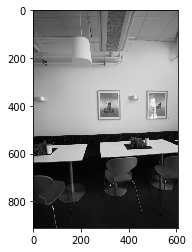

(239, 2)
(239, 2)


In [6]:
img1, img2 = load_img('./images/input1.png', './images/input2.png')
# img1, img2 = load_img('./example-data/CMU2/medium00.JPG', './example-data/CMU2/medium01.JPG')

# Transform to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)


# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)

    # findHomography finds the perspective transformation matrix M of src with respect to dst.
    M = ransac(src_pts,dst_pts,len(good), threshold_distance=0.5, threshold_inliers=0, ransac_iters=50)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    #matchesMask = mask.ravel().tolist()
    h, w, d = img1.shape
    h2, w2, d2 = img2.shape
    pts1 = np.float32([ [0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
    pts2 = np.float32([ [0,0],[0,h2],[w2,h],[w2,0]]).reshape(-1,1,2)
    dst1 = cv2.perspectiveTransform(pts1, M)

#     img2_poly = cv2.polylines(img2,[np.int32(dst1)], True, 255, 3, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

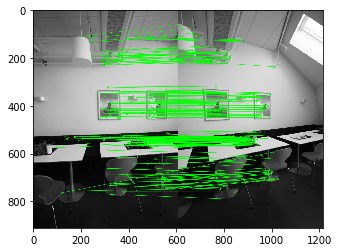

In [7]:
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                    singlePointColor=True,
                    #matchesMask=matchesMask,  # draw only inliers
                    flags=2)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3), plt.show()
plt.imsave('images/match_result.jpg',img3)

In [8]:
# Resulting dimensions
result_dims = np.concatenate((dst1, pts2), axis=0)
print(result_dims)
# Getting images together
# Calculate dimensions of match points
[x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)

[[[ -317.21655273  -168.77513123]]

 [[ -289.95895386  1105.45410156]]

 [[  434.2673645    843.418396  ]]

 [[  418.62017822    60.93442917]]

 [[    0.             0.        ]]

 [[    0.           912.        ]]

 [[  608.           912.        ]]

 [[  608.             0.        ]]]


In [9]:
# shifting the coordinate system such that the coordinate are greater than 0.
# Shifting = transform_array.dot(M), where M is the homography matrix of src with respect to dst.
transform_dist = [-x_min, -y_min]
transform_array = np.array([[1, 0, transform_dist[0]],
                             [0, 1, transform_dist[1]],
                             [0, 0, 1]])

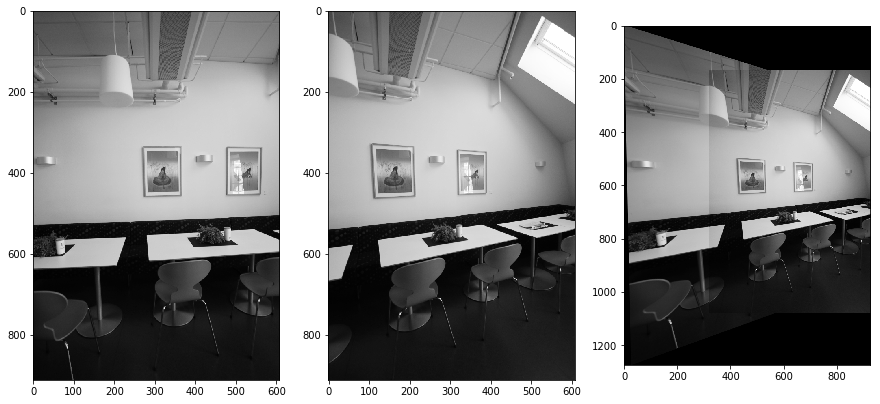

In [10]:
result = cv2.warpPerspective(img1, transform_array.dot(M), (x_max-x_min, y_max-y_min))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

ax[0].imshow(img1)
ax[1].imshow(img2)

shifted_x = result.shape[1] - img2.shape[1]
img1_homo = result.copy()
result[-y_min:-y_min + img2.shape[0], -x_min:-x_min + img2.shape[1]] = img2
plt.imsave('images/tmp.jpg',result)
ax[2].imshow(result)


In [11]:
def gaus_pyramid(img, size):
    G = img.copy()
    gp = [G]
    for i in range(size):
        G = cv2.pyrDown(G)
        gp.append(G)
    
    return gp

In [12]:
def lap_pyramid(gp, size):
    lp = [gp[size-1]]
    for i in range(size-1,0,-1):
        GE = cv2.pyrUp(gp[i], dstsize=(gp[i-1].shape[1], gp[i-1].shape[0]))
        L = cv2.subtract(gp[i-1], GE)
        lp.append(L)
    
    return lp

In [13]:
pysize = 4
# generate Gaussian pyramid for A and B
gpA = gaus_pyramid(img1_homo, pysize)
gpB = gaus_pyramid(img2, pysize)

# generate Laplacian Pyramid for A and B
lpA = [gpA[pysize-1]]
lpA = lap_pyramid(gpA, pysize)
lpB = [gpB[pysize-1]]
lpB = lap_pyramid(gpB, pysize)

In [14]:
# Now add left and right halves of images in each level
LS = []
count = 0
for la,lb in zip(lpA,lpB):
    rows, cols, dpt = la.shape
    py_ymin = int(y_min/(pow(2, pysize-1-count)))
    py_xmin = int(x_min/(pow(2, pysize-1-count)))
    img2_pad = la.copy()
    img2_pad[-py_ymin:-py_ymin + lb.shape[0], -py_xmin:-py_xmin + lb.shape[1]] = lb
    count += 1
    LS.append(img2_pad)

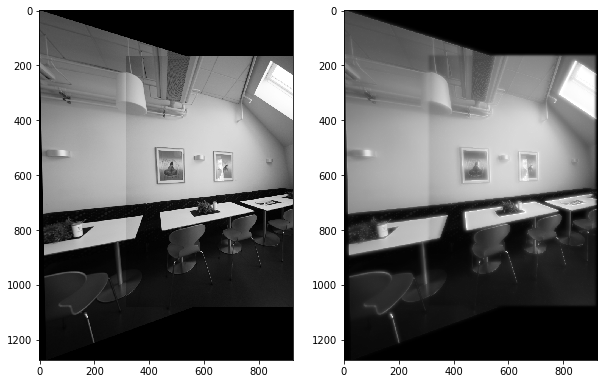

In [15]:
# now reconstruct
ls_ = LS[0]
for i in range(1, pysize):
    ls_ = cv2.pyrUp(ls_, dstsize=(LS[i].shape[1], LS[i].shape[0]))
    ls_ = cv2.add(ls_, LS[i])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(result)
ax[1].imshow(ls_)